# **CommonLit Readability Assessment**
## Determinining Performance with RoBERTa Base

**_Sections:_**
- _Required Packages & Helpers_
- _Configuration_
- _Data Preparation_
- _Modeling_
- _Evaluation_
- _Submission_

**_References (My Earlier Related Work):_**
1. [*Exploratory Data Analysis (EDA)*](https://www.kaggle.com/pradipkumardas/1-commonlit-readability-eda)
2. [*Baselining Model Performance with 1D ConvNet*](https://www.kaggle.com/pradipkumardas/2-commonlit-readability-baseline-perf-1dconvnet)
3. [*Simple Model with BERT*](https://www.kaggle.com/pradipkumardas/3-commonlit-readability-simple-model-with-bert)

_**Note:** This notebook just fine-tunes pretrained RoBERTa (base) model with cross validation, and tries to find if RoBERTa (base) performs better than BERT (base, uncased) where the latter one was experimented in previous notebook (without cross validation through). Other advanced options and techniques based on this findings will be explored and shared soon._

## Required Packages & Helpers

In [1]:
# Imports required packages

import random
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from transformers import TFAutoModelForSequenceClassification, AutoTokenizer

import matplotlib.pyplot as plt
import seaborn as sns

import gc

## Configurations

In [2]:
# Sets data configurations

data_config ={
    "n_bins": 20,
    "n_splits": 5    
}

In [3]:
# Sets model specific configurations

model_config = {
    "model_name": "../input/huggingface-roberta-variants/roberta-base/roberta-base",
    "model_path": "model.h5",
    "num_labels": 1,
    "learning_rate": 5e-5,
    "batch_size": 32,
    "max_length": 256,
    "epochs": 30,
}

In [4]:
# Seeds to reproduce experiment results
random.seed(42)
np.random.seed(42)

# Setting initialization for the theme of the plots
sns.set_theme(style="whitegrid")

## Data Preparation

In [5]:
# Loads data

train = pd.read_csv("../input/commonlitreadabilityprize/train.csv")
test = pd.read_csv("../input/commonlitreadabilityprize/test.csv")
submission = pd.read_csv("../input/commonlitreadabilityprize/sample_submission.csv")

**Segmenting Labels (Distributing Lables in Discrete Intervals)**: As target is a interval variable, these labels should be segmented so that nearly equal number of samples from each segment can be selected during training model.

In [6]:
# Segments discrete interval of label by marking each sample with a bin number

train["bin"] = pd.cut(
    x=train.target, bins=data_config["n_bins"], 
    labels=[i for i in range(data_config["n_bins"])])

## Modeling

In [7]:
training_history = []    # Stores the training and validation performance during cross validation
prediction_history = []  # Stores the prediction against test data to aggregate upon while submission

In [8]:
# Creates tokenizer to prepare data for model training

tokenizer = AutoTokenizer.from_pretrained(model_config["model_name"])

In [9]:
# Prepares test data in TensorFlow dataset format

test_encodings = tokenizer(
    test.excerpt.tolist(), 
    max_length=model_config["max_length"], 
    truncation=True, 
    padding="max_length",
    return_tensors="tf")

test_dataset = tf.data.Dataset.from_tensor_slices(
    {"input_ids": test_encodings["input_ids"], "attention_mask": test_encodings["attention_mask"]})
test_dataset = test_dataset.batch(model_config["batch_size"])
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)

In [10]:
"""
Performs cross validation
"""

# Applies stratified cross validation to have equal distribution for different target bins 

cv = StratifiedKFold(data_config["n_splits"], shuffle=True)

cv_generator = cv.split(train, y=train.bin)

for fold, (idx_train, idx_val) in enumerate(cv_generator):
    
    print(f"FOLD {fold+1}...")
    
    # Encodes training data
    train_encodings = tokenizer(
        train.excerpt.iloc[idx_train].tolist(), 
        max_length=model_config["max_length"], 
        truncation=True, 
        padding="max_length",
        return_tensors="tf")

    # Encodes validation data
    val_encodings = tokenizer(
        train.excerpt.iloc[idx_val].tolist(), 
        max_length=model_config["max_length"], 
        truncation=True, 
        padding="max_length",
        return_tensors="tf")
    
    # Creates TensorFlow dataset out of training data encodings
    train_dataset = tf.data.Dataset.from_tensor_slices((
        {"input_ids": train_encodings["input_ids"], "attention_mask": train_encodings["attention_mask"]},
        train.target.iloc[idx_train]))
    train_dataset = train_dataset.shuffle(1024)
    train_dataset = train_dataset.batch(model_config["batch_size"])
    train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

    # Creates TensorFlow dataset out of validation data encodings
    val_dataset = tf.data.Dataset.from_tensor_slices((
        {"input_ids": val_encodings["input_ids"], "attention_mask": val_encodings["attention_mask"]},
        train.target.iloc[idx_val]))
    val_dataset = val_dataset.batch(model_config["batch_size"])
    val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
    
    # Creates encoder from Transformer
    encoder = TFAutoModelForSequenceClassification.from_pretrained(
    model_config["model_name"], num_labels = model_config["num_labels"])

    # Creates multi inputs for model
    input_ids = layers.Input(shape=(model_config["max_length"], ), dtype=tf.int32, name="input_ids")
    attention_mask = layers.Input(shape=(model_config["max_length"]), dtype=tf.int32, name="attention_mask")

    # Sets model output
    outputs = encoder({"input_ids": input_ids, "attention_mask": attention_mask})

    # Wraps all layers within a model object
    model = Model(inputs=[input_ids, attention_mask], outputs=outputs)

    # Compiles and shows the summary to check
    model.compile(
        optimizer=keras.optimizers.Adam(model_config["learning_rate"]),
        loss=keras.losses.MeanSquaredError(),
        metrics=keras.metrics.RootMeanSquaredError())

    # Configures monitor with rules for model training to stop if criterion match
    early_stopping_monitor = EarlyStopping(
        monitor="val_root_mean_squared_error", mode="min", patience=5, restore_best_weights=True, verbose=1)

    # Configures rules to store model parameters (only weights) at its best during training
    checkpoint = ModelCheckpoint(
        model_config["model_path"], monitor="val_root_mean_squared_error", mode="min", save_best_only=True, save_weights_only=True)

    # Fits the model
    history = model.fit(
        x=train_dataset,
        validation_data=val_dataset,
        callbacks=[early_stopping_monitor, checkpoint],
        epochs=model_config["epochs"],
        verbose=2).history
    
    # Adds the model training history into list for later analysis
    training_history.append(history)
    best_epoch = np.argmin(history["val_root_mean_squared_error"])
    print(f"\nBest Validation Performance: {history['val_root_mean_squared_error'][best_epoch]} (RMSE) at epoch {best_epoch + 1}")
    
    # Predicts on test data and appends the prediction into list to average later
    predictions = model.predict(test_dataset)["logits"]
    prediction_history.append(predictions)
    print("\nPerformed predictions using current model on test dataset and values were recorded.\n")
    
    # Frees resources
    del checkpoint, early_stopping_monitor, model, outputs, encoder
    del val_dataset, train_dataset, train_encodings, val_encodings
    gc.collect()

FOLD 1...


All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at ../input/huggingface-roberta-variants/roberta-base/roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/30
71/71 - 89s - loss: 0.5259 - root_mean_squared_error: 0.7252 - val_loss: 0.3178 - val_root_mean_squared_error: 0.5638
Epoch 2/30
71/71 - 72s - loss: 0.2547 - root_mean_squared_error: 0.5047 - val_loss: 0.4670 - val_root_mean_squared_error: 0.6834
Epoch 3/30
71/71 - 72s - loss: 0.1572 - root_mean_squared_error: 0.3965 - val_loss: 0.4623 - val_root_mean_squared_error: 0.6800
Epoch 4/30
71/71 - 72s - loss: 0.1195 - root_mean_squared_error: 0.3457 - val_loss: 0.5073 - val_root_mean_squared_error: 0.7122
Epoch 5/30
71/71 - 72s - loss: 0.0736 - root_mean_squared_error: 0.2712 - val_loss: 0.3041 - val_root_mean_squared_error: 0.5515
Epoch 6/30
71/71 - 72s - loss: 0.0607 - root_mean_squared_error: 0.2463 - val_loss: 0.5264 - val_root_mean_squared_error: 0.7255
Epoch 7/30
71/71 - 72s - loss: 0.0455 - root_mean_squared_error: 0.2133 - val_loss: 0.3867 - val_root_mean_squared_error: 0.6218
Epoch 8/30
71/71 - 72s - loss: 0.0354 - root_mean_squared_error: 0.1881 - val_loss: 0.4234 - val_

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at ../input/huggingface-roberta-variants/roberta-base/roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/30
71/71 - 88s - loss: 0.6412 - root_mean_squared_error: 0.8008 - val_loss: 0.3716 - val_root_mean_squared_error: 0.6096
Epoch 2/30
71/71 - 72s - loss: 0.2733 - root_mean_squared_error: 0.5228 - val_loss: 0.3242 - val_root_mean_squared_error: 0.5694
Epoch 3/30
71/71 - 72s - loss: 0.1772 - root_mean_squared_error: 0.4210 - val_loss: 0.2572 - val_root_mean_squared_error: 0.5072
Epoch 4/30
71/71 - 72s - loss: 0.1135 - root_mean_squared_error: 0.3369 - val_loss: 0.3885 - val_root_mean_squared_error: 0.6233
Epoch 5/30
71/71 - 72s - loss: 0.0646 - root_mean_squared_error: 0.2541 - val_loss: 0.3484 - val_root_mean_squared_error: 0.5903
Epoch 6/30
71/71 - 72s - loss: 0.0535 - root_mean_squared_error: 0.2314 - val_loss: 0.2923 - val_root_mean_squared_error: 0.5407
Epoch 7/30
71/71 - 72s - loss: 0.0450 - root_mean_squared_error: 0.2122 - val_loss: 0.2847 - val_root_mean_squared_error: 0.5335
Epoch 8/30
71/71 - 72s - loss: 0.0357 - root_mean_squared_error: 0.1890 - val_loss: 0.4296 - val_

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at ../input/huggingface-roberta-variants/roberta-base/roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/30
71/71 - 90s - loss: 0.5709 - root_mean_squared_error: 0.7556 - val_loss: 0.3280 - val_root_mean_squared_error: 0.5727
Epoch 2/30
71/71 - 72s - loss: 0.3192 - root_mean_squared_error: 0.5650 - val_loss: 0.3653 - val_root_mean_squared_error: 0.6044
Epoch 3/30
71/71 - 72s - loss: 0.1789 - root_mean_squared_error: 0.4229 - val_loss: 0.2922 - val_root_mean_squared_error: 0.5406
Epoch 4/30
71/71 - 72s - loss: 0.1359 - root_mean_squared_error: 0.3687 - val_loss: 0.3595 - val_root_mean_squared_error: 0.5996
Epoch 5/30
71/71 - 72s - loss: 0.0841 - root_mean_squared_error: 0.2901 - val_loss: 0.2948 - val_root_mean_squared_error: 0.5429
Epoch 6/30
71/71 - 72s - loss: 0.0579 - root_mean_squared_error: 0.2406 - val_loss: 0.4483 - val_root_mean_squared_error: 0.6696
Epoch 7/30
71/71 - 72s - loss: 0.0418 - root_mean_squared_error: 0.2045 - val_loss: 0.3566 - val_root_mean_squared_error: 0.5972
Epoch 8/30
71/71 - 72s - loss: 0.0354 - root_mean_squared_error: 0.1882 - val_loss: 0.2971 - val_

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at ../input/huggingface-roberta-variants/roberta-base/roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/30
71/71 - 90s - loss: 0.5778 - root_mean_squared_error: 0.7601 - val_loss: 0.4396 - val_root_mean_squared_error: 0.6630
Epoch 2/30
71/71 - 72s - loss: 0.2620 - root_mean_squared_error: 0.5119 - val_loss: 0.3974 - val_root_mean_squared_error: 0.6304
Epoch 3/30
71/71 - 72s - loss: 0.1842 - root_mean_squared_error: 0.4292 - val_loss: 0.5020 - val_root_mean_squared_error: 0.7085
Epoch 4/30
71/71 - 72s - loss: 0.1215 - root_mean_squared_error: 0.3486 - val_loss: 0.2999 - val_root_mean_squared_error: 0.5477
Epoch 5/30
71/71 - 72s - loss: 0.0728 - root_mean_squared_error: 0.2699 - val_loss: 0.3209 - val_root_mean_squared_error: 0.5665
Epoch 6/30
71/71 - 72s - loss: 0.0514 - root_mean_squared_error: 0.2266 - val_loss: 0.4618 - val_root_mean_squared_error: 0.6795
Epoch 7/30
71/71 - 72s - loss: 0.0413 - root_mean_squared_error: 0.2032 - val_loss: 0.3054 - val_root_mean_squared_error: 0.5526
Epoch 8/30
71/71 - 72s - loss: 0.0321 - root_mean_squared_error: 0.1791 - val_loss: 0.3354 - val_

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at ../input/huggingface-roberta-variants/roberta-base/roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/30
71/71 - 91s - loss: 0.6299 - root_mean_squared_error: 0.7936 - val_loss: 0.4200 - val_root_mean_squared_error: 0.6480
Epoch 2/30
71/71 - 72s - loss: 0.3174 - root_mean_squared_error: 0.5633 - val_loss: 0.2621 - val_root_mean_squared_error: 0.5120
Epoch 3/30
71/71 - 72s - loss: 0.1894 - root_mean_squared_error: 0.4352 - val_loss: 0.3239 - val_root_mean_squared_error: 0.5692
Epoch 4/30
71/71 - 72s - loss: 0.1200 - root_mean_squared_error: 0.3464 - val_loss: 0.2895 - val_root_mean_squared_error: 0.5380
Epoch 5/30
71/71 - 72s - loss: 0.0734 - root_mean_squared_error: 0.2710 - val_loss: 0.2793 - val_root_mean_squared_error: 0.5285
Epoch 6/30
71/71 - 72s - loss: 0.0687 - root_mean_squared_error: 0.2621 - val_loss: 0.2599 - val_root_mean_squared_error: 0.5098
Epoch 7/30
71/71 - 72s - loss: 0.0515 - root_mean_squared_error: 0.2269 - val_loss: 0.3547 - val_root_mean_squared_error: 0.5956
Epoch 8/30
71/71 - 72s - loss: 0.0381 - root_mean_squared_error: 0.1952 - val_loss: 0.4611 - val_

## Evaluation

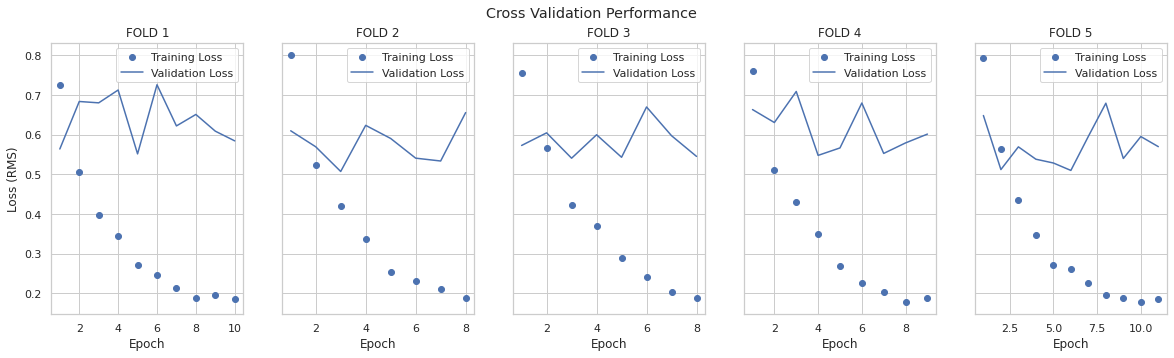

In [11]:
# Plots Model's Cross Validation Performance 

fig, axes = plt.subplots(1, 5, sharey=True, figsize=(20,5))
fig.suptitle("Cross Validation Performance")
for ax, history in enumerate(training_history):
    axes[ax].plot(range(1, len(history["root_mean_squared_error"]) + 1), history["root_mean_squared_error"], "bo", label="Training Loss")
    axes[ax].plot(range(1, len(history["val_root_mean_squared_error"]) + 1), history["val_root_mean_squared_error"], "b", label="Validation Loss")
    axes[ax].set_title(f"FOLD {ax+1}")
    axes[ax].set_xlabel("Epoch")
    axes[ax].legend()
    if ax == 0:
        axes[ax].set_ylabel("Loss (RMS)")

## Submission

In [12]:
# Predicts on test data

mean_predictions = np.mean(prediction_history, axis=0)

In [13]:
# Averaging predictions across folds

submission.target = mean_predictions

In [14]:
# Submitting by saving predictions into submission file

submission.to_csv("submission.csv", index=False)

In [15]:
submission

,id,target
0,c0f722661,-0.153074
1,f0953f0a5,-0.173293
2,0df072751,-0.293639
3,04caf4e0c,-2.463359
4,0e63f8bea,-1.749592
5,12537fe78,-1.149923
6,965e592c0,0.439928
